In [7]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

Running the following at the terminal provides (after a few seconds of thinking) the total line length of the file.

```
% wc -l data/train.csv 
629145481 data/train.csv
```

Certainly too much for my pathetic laptop to read all at once. 

## Loading Sample Data

What do the first 10,000,000 lines look like?

In [4]:
sample_raw_data = pd.read_csv('data/train.csv', sep=',', nrows=10000000)

In [3]:
sample_raw_data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


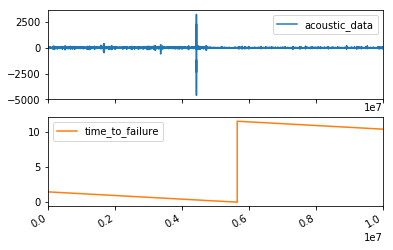

In [4]:
sample_raw_data.plot(subplots=True);

In [5]:
sample_raw_data['time_to_failure'].min()

0.0007954798229500001

Clearly the step size is super tiny here. Interesting little bump maybe 200-300ms before "failure". 

## Counting Number of Quake Events

Ok let's see if I can read in the data bit by bit and figure out how many quakes are in the full training file.

In [6]:
np.sum(sample_raw_data['time_to_failure'].diff().shift(-1) > 0)

1

In [7]:
train_reader = pd.read_csv('data/train.csv', sep=',', chunksize=10000000)

quakes = 0
for chunk in train_reader:
    quakes += np.sum(chunk['time_to_failure'].diff().shift(-1) > 0)
    
    
print(quakes)

16


I'd like to take a closer look at one of the sections of data and apply some transforms to see if anything stands out.

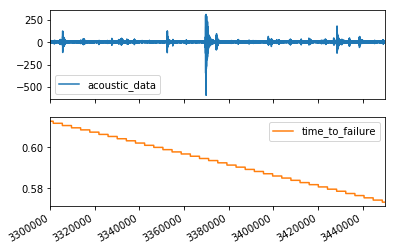

In [5]:
bump_start = 3300000

bump_sample = sample_raw_data.loc[bump_start:bump_start + 150000 - 1]
bump_sample.plot(subplots=True);

In [6]:
t_step = -np.mean(bump_sample['time_to_failure'].diff().shift(-1))
t_step

2.6199035793571947e-07

## Loading Specific Data Chunks With Pandas

In [6]:
specific_raw_data = pd.read_csv('data/train.csv', sep=',', skiprows=524328831, nrows=150000, header=0)

In [7]:
specific_raw_data.head()

,3,1.1563955383
0,7,1.156396
1,2,1.156396
2,2,1.156396
3,5,1.156396
4,4,1.156396


In [14]:
split_index = np.arange(0, 200)
np.random.choice(split_index, size=10)

array([ 76,  98, 137, 177, 124, 107,  47,  40,  59,  44])

In [5]:
# don't do this
#full_raw_data = pd.read_csv('data/train.csv', sep=',', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16})

## Loading Data Chunks With Dask

In [2]:
import dask
import dask.dataframe as dd

In [2]:
data_dask = dd.read_csv("data/train.csv",  dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, blocksize=25e6)

In [3]:
array_dask = data_dask.to_dask_array(lengths=True)
array_dask = dask.array.rechunk(array_dask, chunks=(150000, 2))
array_dask[500000:510000:,]

dask.array<getitem, shape=(10000, 2), dtype=float64, chunksize=(10000, 2)>

In [4]:
array_dask[500000:510000:,].compute()

array([[ 1.        ,  1.33929967],
       [-2.        ,  1.33929967],
       [ 0.        ,  1.33929966],
       ...,
       [ 7.        ,  1.33719768],
       [ 2.        ,  1.33719768],
       [ 8.        ,  1.33719768]])

In [5]:
sample_index = np.random.choice(629145479, size=3)

data_list = []
target_list = []
for i in range(0, 3):
    sample_data = array_dask[sample_index[i]:sample_index[i]+150000].compute()
    data_list.append(sample_data[:,0])
    target_list.append(sample_data[-1,1])
    print(sample_data.shape)

(150000, 2)
(150000, 2)
(150000, 2)


In [6]:
n = 5
sample_index_start = np.random.choice(629145479, size=n)

In [7]:
l = 10
sample_index = [np.arange(i, i+l) for i in sample_index_start]
ts_sample = array_dask[:, 0][np.concatenate(sample_index)].reshape((n, l))
ts_sample.compute()

array([[ 5.,  6.,  7.,  1.,  3.,  5.,  6.,  4.,  3.,  4.],
       [ 8., 10., 10.,  7.,  5.,  3.,  4.,  5.,  2.,  5.],
       [ 5.,  0., -1.,  2.,  3.,  1.,  5.,  3.,  6.,  4.],
       [ 5.,  3.,  4.,  7.,  4.,  6.,  5.,  2.,  3.,  8.],
       [ 7., 11.,  6.,  4.,  5.,  3.,  4.,  5., 10.,  6.]])

In [8]:
st_size = 4
overlap_size = 2

resample_index = np.concatenate([np.arange(i, i+st_size) for i in np.arange(0, l - st_size + 1, st_size - overlap_size)])
resample_index

array([0, 1, 2, 3, 2, 3, 4, 5, 4, 5, 6, 7, 6, 7, 8, 9])

In [9]:
ts_sample[:, resample_index].reshape((n, st_size, -1)).compute()

array([[[ 5.,  6.,  7.,  1.],
        [ 7.,  1.,  3.,  5.],
        [ 3.,  5.,  6.,  4.],
        [ 6.,  4.,  3.,  4.]],

       [[ 8., 10., 10.,  7.],
        [10.,  7.,  5.,  3.],
        [ 5.,  3.,  4.,  5.],
        [ 4.,  5.,  2.,  5.]],

       [[ 5.,  0., -1.,  2.],
        [-1.,  2.,  3.,  1.],
        [ 3.,  1.,  5.,  3.],
        [ 5.,  3.,  6.,  4.]],

       [[ 5.,  3.,  4.,  7.],
        [ 4.,  7.,  4.,  6.],
        [ 4.,  6.,  5.,  2.],
        [ 5.,  2.,  3.,  8.]],

       [[ 7., 11.,  6.,  4.],
        [ 6.,  4.,  5.,  3.],
        [ 5.,  3.,  4.,  5.],
        [ 4.,  5., 10.,  6.]]])

In [10]:
len(array_dask[:, 0])

629145480

In [11]:
n = 5
l = 100
st_size = 50
overlap_size = 25

def get_random_samples(x, n, l):
    sample_index_start = np.random.choice(len(x) - l, size=n)
    sample_index = [np.arange(i, i+l) for i in sample_index_start]
    samples = x[np.concatenate(sample_index)].reshape((n, l))
    return(samples, sample_index_start)

def overlapping_resample(x, sample_size, overlap_size):
    resample_index = np.concatenate([np.arange(i, i + sample_size) for i in np.arange(0, x.shape[1] - sample_size + 1, sample_size - overlap_size)])
    resample = x[:, resample_index].reshape((x.shape[0], -1, sample_size))
    return(resample)

ts_sample, sample_index = get_random_samples(array_dask[:, 0], n, l)
ts_resample = overlapping_resample(ts_sample, st_size, overlap_size)
target = array_dask[sample_index + l, 1]

In [12]:
ts_resample.shape

(5, 3, 50)

In [13]:
target.compute()

array([8.59129885, 1.4799972 , 0.84069571, 5.389199  , 3.86989752])

In [14]:
dask.array.fft.fft(ts_resample)

dask.array<fft, shape=(5, 3, 50), dtype=complex128, chunksize=(1, 3, 50)>

In [27]:
sample_means = ts_resample.mean(axis=-1, keepdims=True)
sample_vars = ts_resample.var(axis=-1, keepdims=True)
sample_stats = dask.array.concatenate([sample_means, sample_vars], axis=2)

In [28]:
sample_means.compute(), sample_vars.compute(), sample_stats.compute()

(array([[[5.22],
         [4.96],
         [5.02]],
 
        [[3.92],
         [5.1 ],
         [4.54]],
 
        [[5.36],
         [4.64],
         [3.54]],
 
        [[4.3 ],
         [4.64],
         [4.98]],
 
        [[5.52],
         [5.12],
         [5.36]]]), array([[[ 8.6516],
         [17.0384],
         [16.9396]],
 
        [[21.9536],
         [41.61  ],
         [36.4884]],
 
        [[ 8.5504],
         [ 9.6704],
         [ 8.1684]],
 
        [[ 7.05  ],
         [ 7.4704],
         [ 6.6996]],
 
        [[ 9.4896],
         [ 8.5056],
         [ 6.8304]]]), array([[[ 5.22  ,  8.6516],
         [ 4.96  , 17.0384],
         [ 5.02  , 16.9396]],
 
        [[ 3.92  , 21.9536],
         [ 5.1   , 41.61  ],
         [ 4.54  , 36.4884]],
 
        [[ 5.36  ,  8.5504],
         [ 4.64  ,  9.6704],
         [ 3.54  ,  8.1684]],
 
        [[ 4.3   ,  7.05  ],
         [ 4.64  ,  7.4704],
         [ 4.98  ,  6.6996]],
 
        [[ 5.52  ,  9.4896],
         [ 5.12  ,  8.5056],

## Testing the Data Loader Class

In [3]:
from prepare_data import LANLDataLoader

loader = LANLDataLoader()
data, target = loader.load_train_data()

In [4]:
data[1].compute().shape

(200, 29, 2619)

In [69]:
target

dask.array<getitem, shape=(200,), dtype=float64, chunksize=(2,)>

In [8]:
data[0].shape[1:]

(29, 4)

In [5]:
loader.get_input_shape()

[(29,), (29,)]

## DFT (Discrete Fourier Transform)
Good info on implementation in the [numpy docs](https://docs.scipy.org/doc/numpy/reference/routines.fft.html#background-information)

In [10]:
from numpy.fft import fft

bump_fft = fft(bump_sample['acoustic_data'])

In [11]:
bump_fft.shape

(150000,)

In [12]:
fft_freqs = np.fft.fftfreq(len(bump_fft)) / t_step / 1000 # in kHz

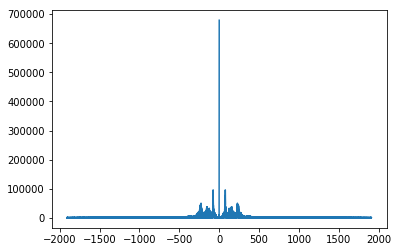

In [13]:
plt.plot(fft_freqs, np.abs(bump_fft));

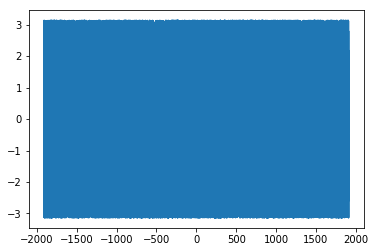

In [14]:
plt.plot(fft_freqs, np.angle(bump_fft));

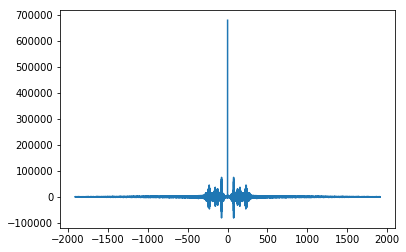

In [15]:
plt.plot(fft_freqs, np.real(bump_fft));

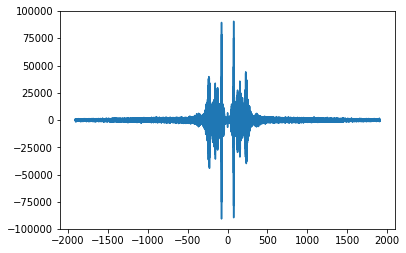

In [16]:
plt.plot(fft_freqs, np.imag(bump_fft));

Lots of low frequency components. 

(0, 100000)

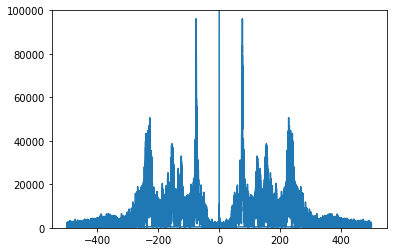

In [17]:
plt.plot(fft_freqs[np.abs(fft_freqs) < 500], np.abs(bump_fft)[np.abs(fft_freqs) < 500])
plt.ylim(0, 100000)

In [18]:
fft_freqs[1]

-0.02544622908718787

### Short-Time DFT

In [38]:
st_size = 20000 # chunk size
overlap_size = 15000 # overlap between chunks
f_cutoff = 500 # frequency cutoff in kHz

# define an iterator for returning chunks of an array
# with some overlap between chunks
def overlapping_chunk(x, length, overlap):
    st_cursor = 0
    while (st_cursor < len(x)):
        if (st_cursor < len(x) - length):
            yield x[st_cursor:st_cursor+length]
        elif (st_cursor < len(x)):
            yield x[st_cursor:]
        st_cursor += st_size - overlap
    
# frequency values returned by fft()
freqs = np.fft.fftfreq(st_size) / t_step / 1000 # in kHz

# iterate over the data sample using the overlapping chunk iterator
stdft_list = []
for stdft_time in overlapping_chunk(bump_sample['acoustic_data'], st_size, overlap_size):
    # perform fft on each chunk
    stdft_freq = fft(stdft_time, n = st_size)
    # filter out frequencies above a given value
    stdft_freq_filtered = stdft_freq[np.abs(freqs) <= f_cutoff]
    # add fft results to the results list
    stdft_list.append(np.fft.fftshift(stdft_freq_filtered))
    
# combine results to create a matrix
stdft_stack = np.stack(stdft_list, axis=1)

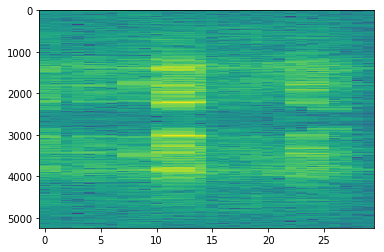

In [39]:
plt.imshow(np.log(np.abs(stdft_stack)), aspect='auto');

## Wavelet Analysis

- Info on wavelet selection [from the MATLAB docs](https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html)
- Wavelet support on noisy data [again from MATLAB](https://www.mathworks.com/help/wavelet/gs/effect-of-wavelet-support-on-noisy-data.html)

## LSTM Model Using STDFT

In [3]:
from prepare_data import LANLDataLoader

loader = LANLDataLoader()
data, target = loader.load_train_data()

2019-03-21 21:55:55,475 - DEBUG - Loading training data...
2019-03-21 21:57:52,295 - DEBUG - Done
2019-03-21 21:57:52,297 - DEBUG - Preparing 200 random samples...
2019-03-21 21:57:54,786 - DEBUG - Calculating rolling statistics...
2019-03-21 21:57:54,824 - DEBUG - Performing DFT...
2019-03-21 21:57:54,846 - DEBUG - Calculating input shapes...
2019-03-21 21:57:55,714 - DEBUG - Done


In [ ]:
from keras.models import Sequential, Model
from keras.layers import CuDNNLSTM, LSTM, Dense, Dropout, Input, Reshape, concatenate
from keras.regularizers import l2

In [13]:
dask.array.percentile(data[1].ravel(), q=[25, 50, 75]).compute()

ValueError: cannot convert float NaN to integer

In [20]:
np.percentile(data[1], [20, 50, 80])

array([-3.25294011e+02-161.04614903j,  2.72474963e-01-248.26133294j,
        3.26925671e+02-198.60240467j])